[nltk_data] Downloading package punkt to /Users/joe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/joe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/joe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Random Forest:
Accuracy: 0.9566326530612245
Confusion Matrix:
 [[171   5]
 [ 12 204]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       176
           1       0.98      0.94      0.96       216

    accuracy                           0.96       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.96      0.96       392


Stacking Classifier:
Accuracy: 0.9566326530612245
Confusion Matrix:
 [[170   6]
 [ 11 205]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       176
           1       0.97      0.95      0.96       216

    accuracy                           0.96       392
   macro avg       0.96      0.96      0.96       392
weighted avg       0.96      0.96      0.96       392


Stacking Classifier Cross-Validation Scores: [0.97444089 0.96166134 0.96485623 0.96166134 0.97115385]
Mean Cross-Valid

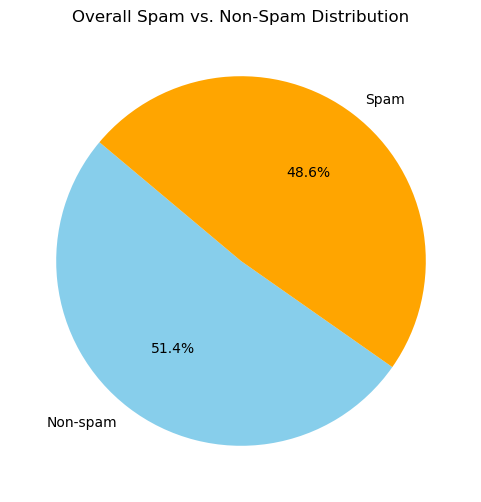

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv('Youtube-Spam-Dataset.csv')
df = df.drop(columns=['COMMENT_ID'])

# Preprocess text
def preprocess_text(text, use_stemming=True):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    if use_stemming:
        stemmer = PorterStemmer()
        processed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    else:
        lemmatizer = WordNetLemmatizer()
        processed_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(processed_tokens)

df['PROCESSED_COMMENT'] = df['CONTENT'].apply(lambda x: preprocess_text(str(x)))

# Feature Engineering
df['comment_length'] = df['CONTENT'].apply(len)
df['num_exclamation'] = df['CONTENT'].apply(lambda x: x.count('!'))
df['num_uppercase'] = df['CONTENT'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Train-Test Split
X = df[['PROCESSED_COMMENT', 'comment_length', 'num_exclamation', 'num_uppercase']]
y = df['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train['PROCESSED_COMMENT'])
X_test_tfidf = vectorizer.transform(X_test['PROCESSED_COMMENT'])

# Combine TF-IDF with additional features
X_train_combined = hstack([X_train_tfidf, X_train[['comment_length', 'num_exclamation', 'num_uppercase']].values])
X_test_combined = hstack([X_test_tfidf, X_test[['comment_length', 'num_exclamation', 'num_uppercase']].values])

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_combined, y_train)
y_pred_rf = rf_model.predict(X_test_combined)

print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Stacking Classifier
estimators = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
stacking_model.fit(X_train_combined, y_train)
y_pred_stack = stacking_model.predict(X_test_combined)

print("\nStacking Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))

# Cross-validation for Stacking Classifier
stack_cv_scores = cross_val_score(stacking_model, X_train_combined, y_train, cv=5, scoring='accuracy')
print("\nStacking Classifier Cross-Validation Scores:", stack_cv_scores)
print("Mean Cross-Validation Accuracy:", stack_cv_scores.mean())

# Plot Spam vs Non-Spam Distribution
class_counts = df['CLASS'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=['Non-spam', 'Spam'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
plt.title('Overall Spam vs. Non-Spam Distribution')
plt.show()
